# Introduction

This notebook is created for [Kaggle's Sign Langueage Classifier Competition](https://www.kaggle.com/competitions/asl-signs/code)

 [Sign Language EDA & Visualization](https://www.kaggle.com/code/mayukh18/sign-language-eda-visualization).

 [tfdataset-of-google-isl-recognition-data](https://www.kaggle.com/datasets/aapokossi/saved-tfdataset-of-google-isl-recognition-data).

 [Submission for variable length time-series model](https://www.kaggle.com/code/aapokossi/submission-for-variable-length-time-series-model). 

<a id="contents"></a>
# Contents
1. [Import Libraries and Set File Directories](#section-one)
2. [Visualize data](#section-two)
3. [Load Data](#section-three)
4. [Train Model](#section-four)
5. [Submit Model](#section-five)

<a id="section-one"></a>
# Import Libraries and Set File Directories

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from keras.utils.vis_utils import plot_model
from IPython.display import clear_output
from tensorflow.keras import layers, optimizers

2023-05-12 08:38:55.141783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 08:38:56.122562: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-12 08:38:56.122689: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [2]:
# set files directories
LANDMARK_FILES_DIR = "/home/lyuxuan0422/proj/train_landmark_files"
TRAIN_FILE = "/home/lyuxuan0422/proj/train.csv"

<a id="section-two"></a>
# Visualize data

Slightly different from a dataframe, in this competition we will be using a [parquet](https://towardsdatascience.com/demystifying-the-parquet-file-format-13adb0206705). We will read it using the command `read_parquet`.

In [3]:
# read the data, the type of the data
sample = pd.read_parquet("/home/lyuxuan0422/proj/train_landmark_files/16069/100015657.parquet")
sample.head()

,frame,row_id,type,landmark_index,x,y,z
0,103,103-face-0,face,0,0.437886,0.437599,-0.051134
1,103,103-face-1,face,1,0.443258,0.392901,-0.067054
2,103,103-face-2,face,2,0.443997,0.409998,-0.042990
3,103,103-face-3,face,3,0.435256,0.362771,-0.039492
4,103,103-face-4,face,4,0.443780,0.381762,-0.068013


Everyone likes to visualize things right? Since the data is about sequences of hand movement, we might not be able to see it from tabular data only. Let us instead plot the movement into matplotlib.

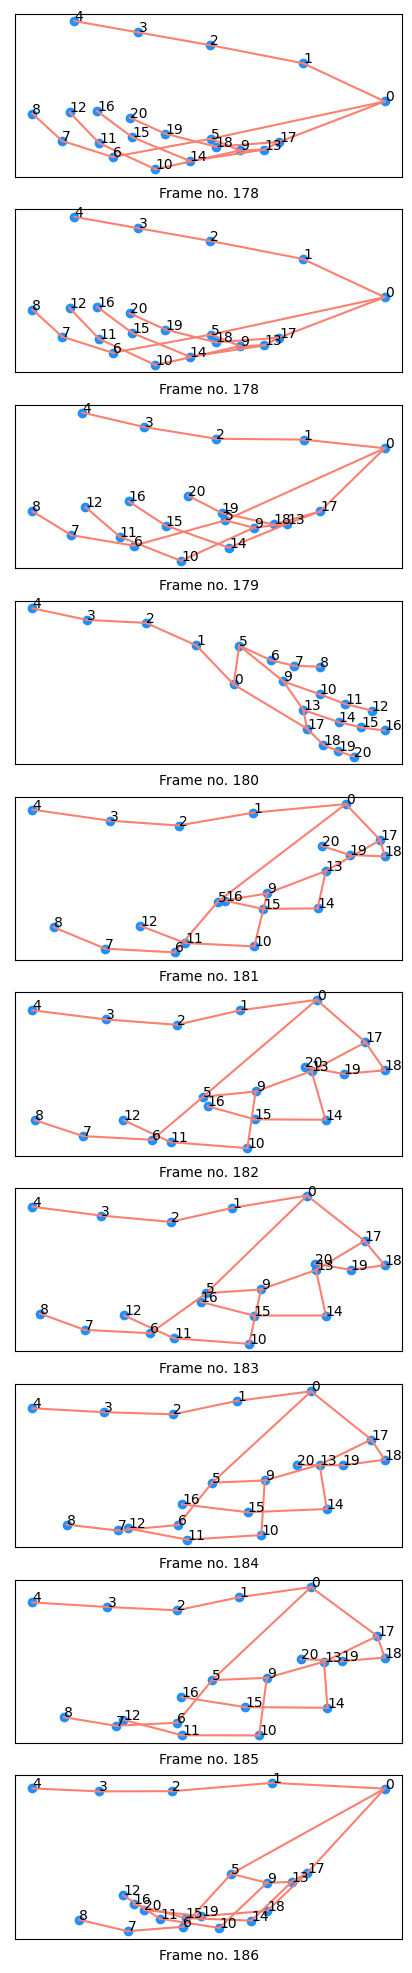

In [4]:
# pick the left hand and right hand points
sample_left_hand = sample[sample.type == "left_hand"]
sample_right_hand = sample[sample.type == "right_hand"]

# edges that represents the hand edges
edges = [(0,1),(1,2),(2,3),(3,4),(0,5),(0,17),(5,6),(6,7),(7,8),(5,9),(9,10),(10,11),(11,12),
         (9,13),(13,14),(14,15),(15,16),(13,17),(17,18),(18,19),(19,20)]

# plotting a single frame into matplotlib
def plot_frame(df, frame_id, ax):
    df = df[df.frame == frame_id].sort_values(['landmark_index'])
    x = list(df.x)
    y = list(df.y)
    
    # plotting the points
    ax.scatter(df.x, df.y, color='dodgerblue')
    for i in range(len(x)):
        ax.text(x[i], y[i], str(i))
    
    # plotting the edges that represents the hand
    for edge in edges:
        ax.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], color='salmon')
        ax.set_xlabel(f"Frame no. {frame_id}")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

# plotting the multiple frames
def plot_frame_seq(df, frame_range, n_frames):
    frames = np.linspace(frame_range[0],frame_range[1],n_frames, dtype = int, endpoint=True)
    fig, ax = plt.subplots(n_frames, 1, figsize=(5,25))
    for i in range(n_frames):
        plot_frame(df, frames[i], ax[i])
        
    plt.show()

plot_frame_seq(sample_left_hand, (178,186), 10)

<a id="section-three"></a>
# Load Data

In [5]:
# Set constants and pick important landmarks
FACIAL_IDX = [0,9,11,13,14,17,117,118,119,199,346,347,348]
LEFT_HAND_IDX = list(range(468,489))
POSE_IDX = list(range(489,522))
RIGHT_HAND_IDX = list(range(522,543))
LANDMARK_IDX = FACIAL_IDX + LEFT_HAND_IDX + POSE_IDX + RIGHT_HAND_IDX
DATA_PATH = "/home/lyuxuan0422/proj/GoogleISLDatasetBatched"
DS_CARDINALITY = 185
VAL_SIZE  = 18
N_SIGNS = 250
ROWS_PER_FRAME = 543
BATCH_SIZE = 512

## To keep it simple, we will use the preprocessed [tf.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) from [tfdataset-of-google-isl-recognition-data](https://www.kaggle.com/datasets/aapokossi/saved-tfdataset-of-google-isl-recognition-data).

In [16]:
def preprocess(ragged_batch, labels):
    ragged_batch = tf.gather(ragged_batch, LANDMARK_IDX, axis=2)
    ragged_batch = tf.where(tf.math.is_nan(ragged_batch), tf.zeros_like(ragged_batch), ragged_batch)
    return tf.concat([ragged_batch[...,i] for i in range(3)],-1), labels

dataset = tf.data.Dataset.load(DATA_PATH)
dataset = dataset.map(preprocess)
val_ds = dataset.take(VAL_SIZE).cache().prefetch(tf.data.AUTOTUNE)
train_ds = dataset.skip(VAL_SIZE).cache().shuffle(20).prefetch(tf.data.AUTOTUNE)

# import numpy as np
# val_elem = val_ds.take(167)
# temp_max = 0
# # Print the elements
# for elem1 in val_elem:
#     elem1 = np.array(elem1, dtype=object)
# #     for i in elem1[0]:
# #         temp_max = max(temp_max, i.shape[0])
# print(temp_max)
# print(elem1[0][5].shape)
# print(elem1[1].shape)
# print(elem1[0].shape)
# elem1.shape
def get_inference_model(model):
    inputs = tf.keras.Input(shape=(ROWS_PER_FRAME,3), name="inputs", ragged=True)
    x = tf.gather(inputs, LANDMARK_IDX, axis=1)
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x = tf.concat([x[...,i] for i in range(3)], -1)
    x = tf.expand_dims(x,0)
    out = model(x)
    out = layers.Activation("linear", name="outputs")(out)
    inference_model = tf.keras.Model(inputs=inputs, outputs=out)
    inference_model.compile(loss="sparse_categorical_crossentropy",
                            metrics="accuracy")
    return inference_model

<a id="section-four"></a>
# Train Model

Now let us get to the fun part, training the model!

In [19]:
class PlotGen(tf.keras.callbacks.Callback):
    
    def __init__(self, name, model):
        self.temp_best = 0
        self.metrics = {}
        self.name = name
        self.model = model
        
    def save_model(self):
        print("---saving model---")
        inference_model = get_inference_model(self.model)
        converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
        tflite_model = converter.convert()
        model_path = self.name
        with open(model_path, 'wb') as f:
            f.write(tflite_model)
        !zip submission.zip $model_path

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            log = logs.get(metric)
            if metric in self.metrics:
                self.metrics[metric].append(log)
            else:
                self.metrics[metric] = [log]
        print(self.metrics)
        if epoch % 5 == 0 and self.metrics["sparse_top_k_categorical_accuracy"][-1] > self.temp_best and "split" not in self.name:
            print(self.model)
            self.temp_best = self.metrics["sparse_top_k_categorical_accuracy"][-1]
            self.save_model()
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), self.metrics[metric], label=metric)
            if metric != "lr":
                axs[i].plot(range(1, epoch + 2), self.metrics['val_' + metric], label='val_' + metric)
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [8]:
# a single dense block followed by a normalization block and relu activation
def dense_block(units, name):
    fc = layers.Dense(units)
    norm = layers.LayerNormalization()
    act = layers.Activation("relu")
    drop = layers.Dropout(0.1)
    return lambda x: drop(act(norm(fc(x))))

# the lstm block with the final dense block for the classification
def classifier_lstm(lstm_units):
    lstm = layers.LSTM(lstm_units)
    out = layers.Dense(N_SIGNS, activation="softmax")
    return lambda x: out(lstm(x))

def classifier_gru(gru_units):
    gru = layers.GRU(gru_units)
    out = layers.Dense(N_SIGNS, activation="softmax")
    return lambda x: out(gru(x))

In [9]:
# choose the number of nodes per layer
encoder_units = [512, 256] # tune this
lstm_units = 250 # tune this

#define the inputs (ragged batches of time series of landmark coordinates)
inputs = tf.keras.Input(shape=(None, 3*len(LANDMARK_IDX)), ragged=True)

# dense encoder model
x = inputs
for i, n in enumerate(encoder_units):
    x = dense_block(n, f"encoder_{i}")(x)

model_simplernn = tf.keras.Sequential([
    tf.keras.Input(shape=(None, 3*len(LANDMARK_IDX)), ragged=True),
    tf.keras.layers.SimpleRNN(512),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(N_SIGNS, activation='softmax')
])
model_simplernn.summary()
plot_model(model_simplernn, to_file='simplernn_plot.png', show_shapes=True, show_layer_names=True)

print()
model_lstm = tf.keras.Model(inputs=inputs, outputs=classifier_lstm(N_SIGNS)(x))
model_lstm.summary()
print()
model_gru = tf.keras.Model(inputs=inputs, outputs=classifier_gru(N_SIGNS)(x))
model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 512)               397824    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 250)               64250     
                                                                 
Total params: 593,402
Trainable params: 593,402
Non-trainable params: 0
_________________________________________________________________

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 264)]       0         
                                                                 
 dense (Dense)               (None

In [10]:
# include early stopping and reducelr
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
reduce_on_plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor = 0.5, patience=3)

def get_callbacks_simplernn():
    return [
        early_stop_callback,
        reduce_on_plateau_callback,
        PlotGen("simplernn.tflite", model_simplernn)
    ]
def get_callbacks_lstm():
    return [
        early_stop_callback,
        reduce_on_plateau_callback,
        PlotGen("lstm.tflite", model_lstm)
    ]

def get_callbacks_gru():
    return [
        early_stop_callback,
        reduce_on_plateau_callback,
        PlotGen("gru.tflite", model_gru)
    ]

# add a decreasing learning rate scheduler to help convergence
steps_per_epoch = DS_CARDINALITY - VAL_SIZE
boundaries = [steps_per_epoch * n for n in [30,50,70]]
values = [1e-3,1e-4,1e-5,1e-6]
lr_sched = optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
optimizer = optimizers.Adam(lr_sched)

model_simplernn.compile(optimizer=optimizers.Adam(optimizers.schedules.PiecewiseConstantDecay(boundaries, values)),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy","sparse_top_k_categorical_accuracy"])
model_lstm.compile(optimizer=optimizers.Adam(optimizers.schedules.PiecewiseConstantDecay(boundaries, values)),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy","sparse_top_k_categorical_accuracy"])
model_gru.compile(optimizer=optimizers.Adam(optimizers.schedules.PiecewiseConstantDecay(boundaries, values)),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy","sparse_top_k_categorical_accuracy"])

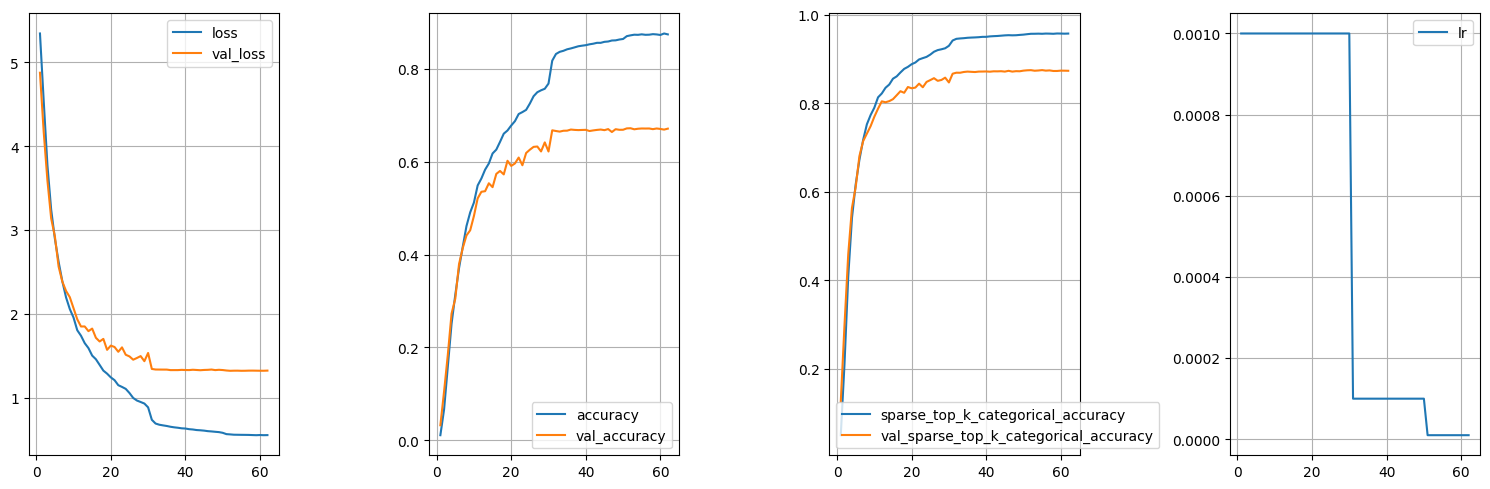

167/167 [==============================] - 40s 237ms/step - loss: 0.5556 - accuracy: 0.8745 - sparse_top_k_categorical_accuracy: 0.9573 - val_loss: 1.3248 - val_accuracy: 0.6714 - val_sparse_top_k_categorical_accuracy: 0.8733 - lr: 1.0000e-05
Simple RNN--- 2790.561333179474 seconds ---


In [11]:
start_time = time.time()
model_lstm.fit(train_ds,
          validation_data = val_ds,
          callbacks = get_callbacks_simplernn(),
          epochs = 100)
print("Simple RNN--- %s seconds ---" % (time.time() - start_time))

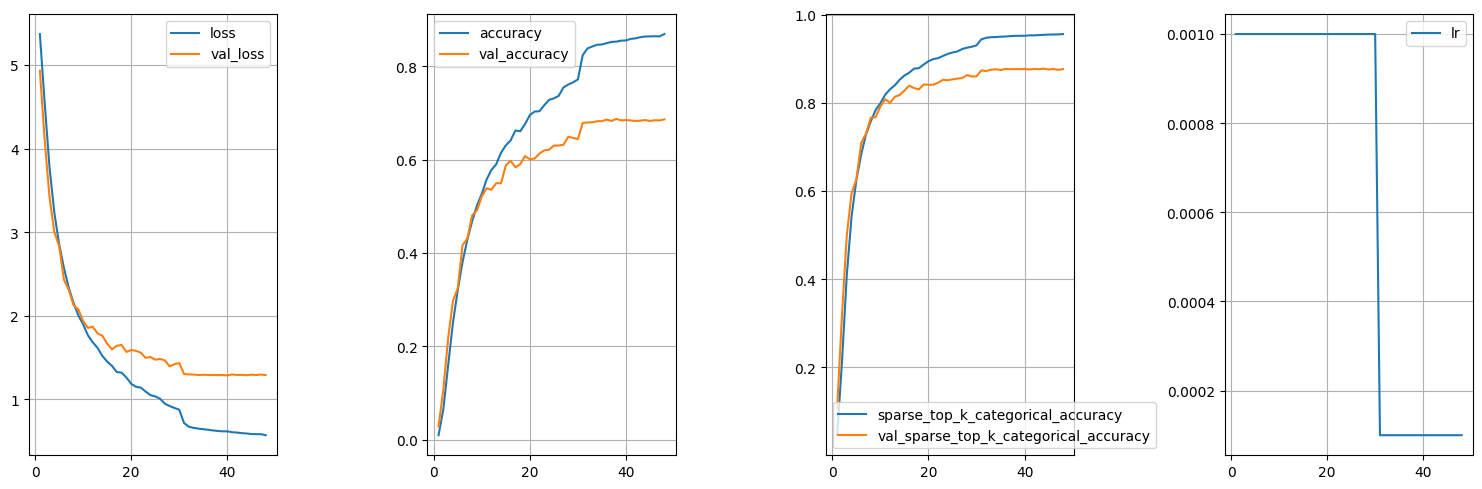

167/167 [==============================] - 42s 252ms/step - loss: 0.5724 - accuracy: 0.8688 - sparse_top_k_categorical_accuracy: 0.9559 - val_loss: 1.2923 - val_accuracy: 0.6862 - val_sparse_top_k_categorical_accuracy: 0.8764 - lr: 1.0000e-04
LSTM--- 2325.5284905433655 seconds ---


In [11]:
start_time = time.time()
model_lstm.fit(train_ds,
          validation_data = val_ds,
          callbacks = get_callbacks_lstm(),
          epochs = 100)
print("LSTM--- %s seconds ---" % (time.time() - start_time))

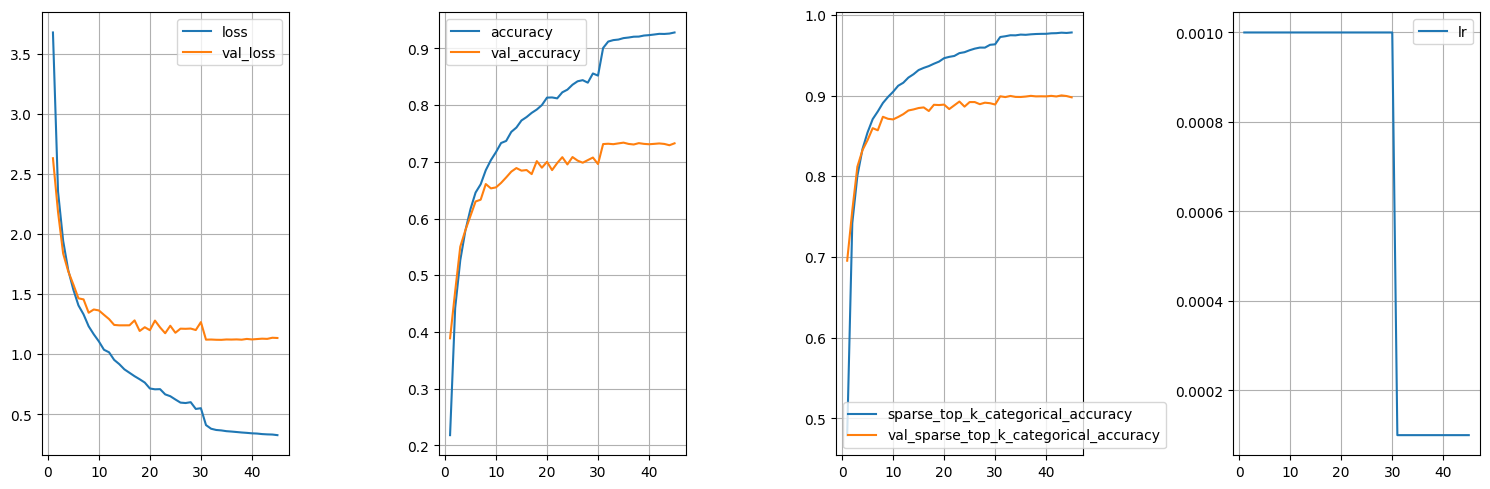

167/167 [==============================] - 39s 235ms/step - loss: 0.3274 - accuracy: 0.9281 - sparse_top_k_categorical_accuracy: 0.9781 - val_loss: 1.1356 - val_accuracy: 0.7326 - val_sparse_top_k_categorical_accuracy: 0.8978 - lr: 1.0000e-04
GRU--- 1858.6157338619232 seconds ---


In [13]:
start_time = time.time()
model_gru.fit(train_ds,
          validation_data = val_ds,
          callbacks = get_callbacks_gru(),
          epochs = 100)
print("GRU--- %s seconds ---" % (time.time() - start_time))

<a id="section-four"></a>
# Train Split LSTM Model

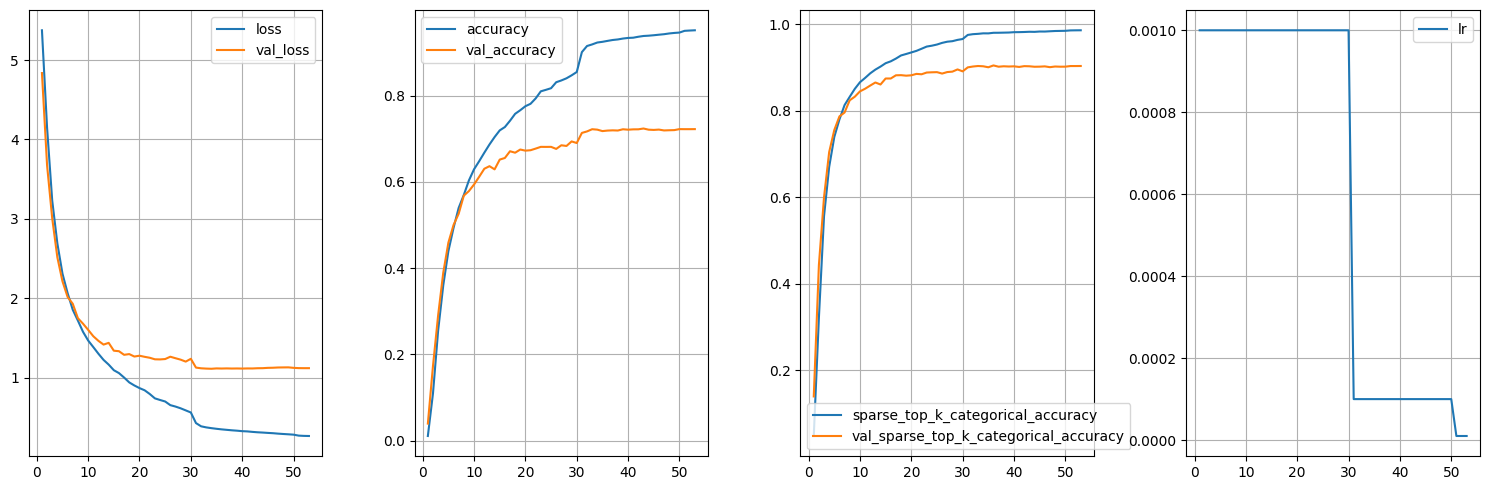

167/167 [==============================] - 105s 626ms/step - loss: 0.2661 - accuracy: 0.9518 - sparse_top_k_categorical_accuracy: 0.9856 - val_loss: 1.1202 - val_accuracy: 0.7225 - val_sparse_top_k_categorical_accuracy: 0.9031 - lr: 1.0000e-05
Split LSTM--- 5583.247515916824 seconds ---


In [15]:
def get_callbacks_split_lstm():
    return [
        early_stop_callback,
        reduce_on_plateau_callback,
        PlotGen("split_lstm.tflite", model_split_lstm)
    ]

def split_lstm_block(inputs, encoder_units):
    for i, n in enumerate(encoder_units):
        inputs = dense_block(n, f"encoder_{i}")(inputs)
    return inputs

inputs = tf.keras.Input(shape=(None, 3 * len(LANDMARK_IDX)), ragged=True)
face_inputs = tf.keras.layers.Concatenate(axis=-1)([inputs[:, :, 0:13], inputs[:, :, 88:101], inputs[:, :, 176:189]])
left_hand_inputs = tf.keras.layers.Concatenate(axis=-1)([inputs[:, :, 13:34], inputs[:, :, 101:122], inputs[:, :, 189:210]])
pose_inputs = tf.keras.layers.Concatenate(axis=-1)([inputs[:, :, 34:67], inputs[:, :, 122:155], inputs[:, :, 210:243]])
right_hand_inputs = tf.keras.layers.Concatenate(axis=-1)([inputs[:, :, 67:88], inputs[:, :, 155:176], inputs[:, :, 243:264]])
face_vector = split_lstm_block(face_inputs, [512, 256])
left_hand_vector = split_lstm_block(left_hand_inputs, [512, 256])
right_hand_vector = split_lstm_block(right_hand_inputs, [512, 256])
pose_vector = split_lstm_block(pose_inputs, [512, 256])
vector = tf.keras.layers.Concatenate(axis=2)([face_vector, left_hand_vector, right_hand_vector, pose_vector])

output = classifier_lstm(N_SIGNS)(vector)

model_split_lstm = tf.keras.Model(inputs=inputs, outputs=output)
#model_split_lstm.summary()
plot_model(model_split_lstm, to_file='split_lstm_plot.png', show_shapes=True, show_layer_names=True)

model_split_lstm.compile(optimizer=optimizers.Adam(optimizers.schedules.PiecewiseConstantDecay(boundaries, values)),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy","sparse_top_k_categorical_accuracy"])

start_time = time.time()
model_split_lstm.fit(train_ds,
          validation_data = val_ds,
          callbacks = get_callbacks_split_lstm(),
          epochs = 100)
print("Conv LSTM--- %s seconds ---" % (time.time() - start_time))

<a id="section-four"></a>
# Train Split GRU Model

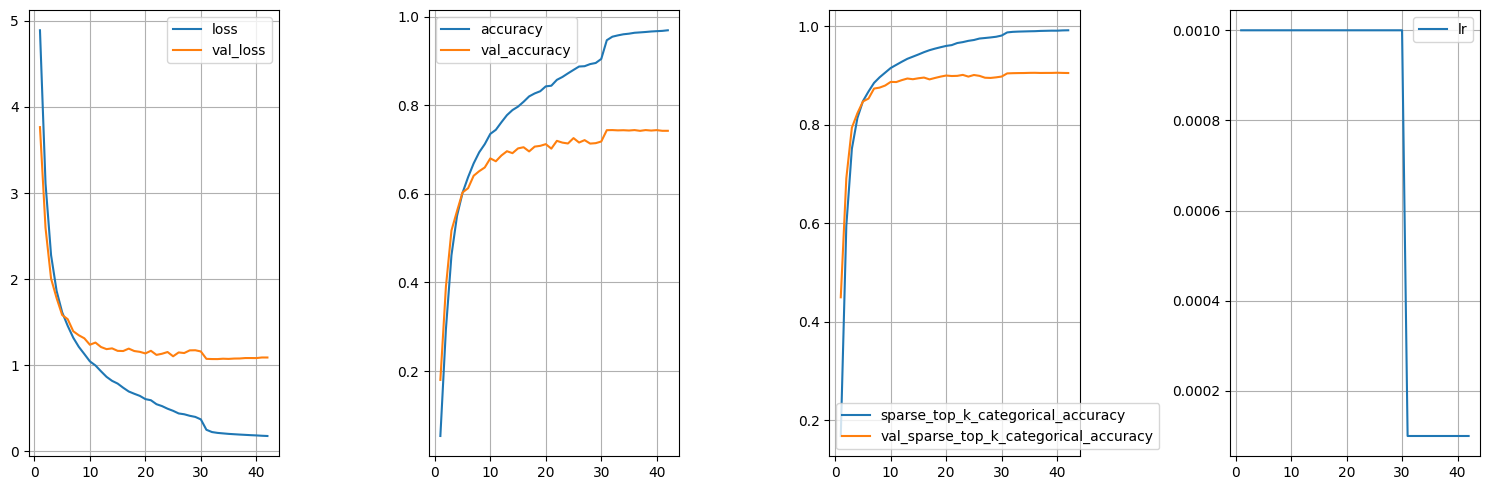

167/167 [==============================] - 101s 603ms/step - loss: 0.1797 - accuracy: 0.9692 - sparse_top_k_categorical_accuracy: 0.9917 - val_loss: 1.0910 - val_accuracy: 0.7423 - val_sparse_top_k_categorical_accuracy: 0.9049 - lr: 1.0000e-04
Split GRU--- 4289.645782470703 seconds ---


In [13]:
def get_callbacks_split_gru():
    return [
        early_stop_callback,
        reduce_on_plateau_callback,
        PlotGen("split_gru.tflite", None)
    ]

def split_gru_block(inputs, encoder_units):
    for i, n in enumerate(encoder_units):
        inputs = dense_block(n, f"encoder_{i}")(inputs)
    return inputs

inputs = tf.keras.Input(shape=(None, 3*len(LANDMARK_IDX)), ragged=True)
face_inputs = tf.keras.layers.Concatenate(axis=-1)([inputs[:, :, 0:13], inputs[:, :, 88:101], inputs[:, :, 176:189]])
left_hand_inputs = tf.keras.layers.Concatenate(axis=-1)([inputs[:, :, 13:34], inputs[:, :, 101:122], inputs[:, :, 189:210]])
pose_inputs = tf.keras.layers.Concatenate(axis=-1)([inputs[:, :, 34:67], inputs[:, :, 122:155], inputs[:, :, 210:243]])
right_hand_inputs = tf.keras.layers.Concatenate(axis=-1)([inputs[:, :, 67:88], inputs[:, :, 155:176], inputs[:, :, 243:264]])
face_vector = split_gru_block(face_inputs, [512, 256])
left_hand_vector = split_gru_block(left_hand_inputs, [512, 256])
right_hand_vector = split_gru_block(right_hand_inputs, [512, 256])
pose_vector = split_gru_block(pose_inputs, [512, 256])
vector = tf.keras.layers.Concatenate(axis=2)([face_vector, left_hand_vector, right_hand_vector, pose_vector])

output = classifier_gru(N_SIGNS)(vector)

model_split_gru = tf.keras.Model(inputs=inputs, outputs=output)
#model_split_lstm.summary()
plot_model(model_split_gru, to_file='split_gru_plot.png', show_shapes=True, show_layer_names=True)

model_split_gru.compile(optimizer=optimizers.Adam(optimizers.schedules.PiecewiseConstantDecay(boundaries, values)),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy","sparse_top_k_categorical_accuracy"])

start_time = time.time()
model_split_gru.fit(train_ds,
          validation_data = val_ds,
          callbacks = get_callbacks_split_gru(),
          epochs = 100)
print("Split GRU--- %s seconds ---" % (time.time() - start_time))

In [17]:
def get_callbacks_split_gru():
    return [
        early_stop_callback,
        reduce_on_plateau_callback,
        PlotGen("split_gru.tflite", None)
    ]

def split_gru_block(inputs, encoder_units):
    for i, n in enumerate(encoder_units):
        inputs = dense_block(n, f"encoder_{i}")(inputs)
    return inputs

inputs = tf.keras.Input(shape=(None, 3*len(LANDMARK_IDX)), ragged=True)
face_inputs = tf.keras.layers.Concatenate(axis=-1)([inputs[:, :, 0:13], inputs[:, :, 88:101], inputs[:, :, 176:189]])
left_hand_inputs = tf.keras.layers.Concatenate(axis=-1)([inputs[:, :, 13:34], inputs[:, :, 101:122], inputs[:, :, 189:210]])
pose_inputs = tf.keras.layers.Concatenate(axis=-1)([inputs[:, :, 34:67], inputs[:, :, 122:155], inputs[:, :, 210:243]])
right_hand_inputs = tf.keras.layers.Concatenate(axis=-1)([inputs[:, :, 67:88], inputs[:, :, 155:176], inputs[:, :, 243:264]])
face_vector = split_gru_block(face_inputs, [512, 256])
left_hand_vector = split_gru_block(left_hand_inputs, [512, 256])
right_hand_vector = split_gru_block(right_hand_inputs, [512, 256])
pose_vector = split_gru_block(pose_inputs, [512, 256])
vector = tf.keras.layers.Concatenate(axis=2)([face_vector, left_hand_vector, right_hand_vector, pose_vector])

output = classifier_gru(N_SIGNS)(vector)

model_split_gru = tf.keras.Model(inputs=inputs, outputs=output)
#model_split_lstm.summary()
plot_model(model_split_gru, to_file='split_gru_plot.png', show_shapes=True, show_layer_names=True)

model_split_gru.compile(optimizer=optimizers.Adam(optimizers.schedules.PiecewiseConstantDecay(boundaries, values)),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy","sparse_top_k_categorical_accuracy"])

start_time = time.time()
model_split_gru.fit(train_ds,
          validation_data = val_ds,
          callbacks = get_callbacks_split_gru(),
          epochs = 100)
print("Split GRU--- %s seconds ---" % (time.time() - start_time))

Epoch 1/100
167/167 [==============================] - ETA: 0s - loss: 4.9270 - accuracy: 0.0492 - sparse_top_k_categorical_accuracy: 0.1592{'loss': [4.927041053771973], 'accuracy': [0.04921359196305275], 'sparse_top_k_categorical_accuracy': [0.1592404544353485], 'val_loss': [3.8230977058410645], 'val_accuracy': [0.1584201455116272], 'val_sparse_top_k_categorical_accuracy': [0.4185112714767456], 'lr': [0.001]}
---saving model---


TypeError: Exception encountered when calling layer 'tf.__operators__.ragged_getitem_42' (type SlicingOpLambda).

Ragged __getitem__ expects a ragged_tensor.

Call arguments received by layer 'tf.__operators__.ragged_getitem_42' (type SlicingOpLambda):
  • rt_input=tf.Tensor(shape=(1, None, 264), dtype=float32)
  • key=({'start': 'None', 'stop': 'None', 'step': 'None'}, {'start': 'None', 'stop': 'None', 'step': 'None'}, {'start': '34', 'stop': '67', 'step': 'None'})

<a id="section-five"></a>
# Submit Model

Now it is time to submit. In this competition, we should submit the model itself.

In [ ]:
model.summary(expand_nested=True)

In [ ]:
inference_model = get_inference_model(model)
inference_model.summary(expand_nested=True)

In [ ]:
# save the model
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()
model_path = "model.tflite"

# submit the model
with open(model_path, 'wb') as f:
    f.write(tflite_model)
!zip submission.zip $model_path